In [85]:
import json
import sys
import os
from rdkit import Chem
from tqdm import tqdm
import selfies as sf
import matplotlib.pyplot as plt

from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer

In [56]:
beam_path = "./generations/beam_search/OPT_1.2B_ep_1_all_canon_finetune_all_canon_sas_3_sf_beam_1M.csv"
rand_path = "./generations/sf/OPT_1.2B_ep_1_all_canon_finetune_all_canon_sas_3_sf_1000K_8.00E-05_hf_iter_3900_gen_1000000__.csv"
subset_path = "../../data/data/subsets/sas_3_sf.jsonl"

In [30]:
with open(beam_path, "r") as f:
    beam_data = f.read().splitlines()          

In [31]:
with open(rand_path, "r") as f:
    rand_data = f.read().splitlines()    

In [32]:
beam_1K = beam_data[:1_000]
beam_10K = beam_data[:10_000]
beam_100K = beam_data[:100_000]
beam_1M = beam_data[:1_000_000]

In [33]:
beam_sizes = [1_000, 10_000, 100_000, 1_000_000, 4_000_000, 7_000_000, 10_000_000]
upper_bound = [0.015, 0.15, 1.5, 13.97, 45.12, 65.01, 77.69]
precision = [ 53.2, 55.33, 55.88, 54.14, 54.24, 50.73, 48.95]
recall =    [ 0.008, 0.083, 0.84, 6.35, 24.33, 36.08, 43.3]

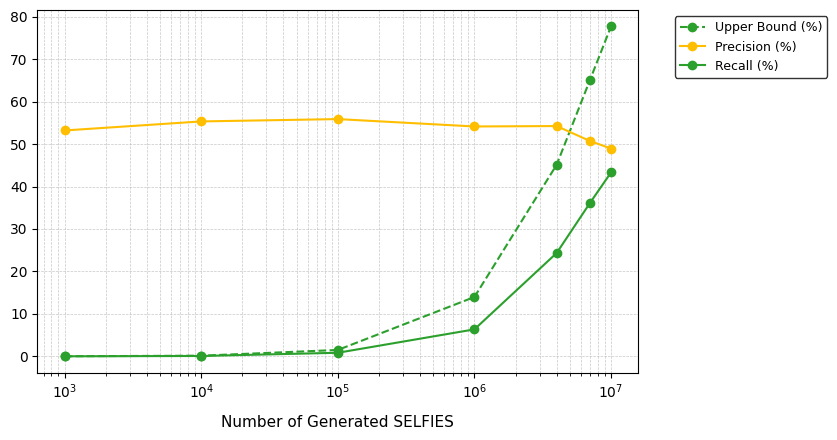

In [34]:
plt.figure(figsize=(8.5, 4.5))

# Add labels and title
plt.xlabel('Number of Generated SELFIES', fontsize=11, labelpad=10)

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('white')

# Plot actual data points
plt.plot(beam_sizes, upper_bound, marker='o', linestyle='--', color='#2ca02c', label='Upper Bound (%)')
plt.plot(beam_sizes, precision, marker='o', linestyle='-', color='#ffbf00', label='Precision (%)')
plt.plot(beam_sizes, recall, marker='o', linestyle='-', color='#2ca02c', label='Recall (%)')
# Position the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, edgecolor='black')
plt.xscale('log')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

In [76]:
chunk = 10
beam_chunk = beam_data[:chunk]
rand_chunk = rand_data[:chunk]

In [77]:
def jsonl_to_list(path):
    with open(path, 'r') as file:
        mol_list = [json.loads(line_str)["text"] for line_str in tqdm(file)]
        return mol_list

In [78]:
subset = jsonl_to_list(subset_path)

6645440it [00:07, 864060.55it/s]


In [79]:
def get_canonical(sf_list):
    sf_canon_list = []

    for b_sf_str in tqdm(sf_list):
        try:
            b_sm_str = sf.decoder(b_sf_str)
            mol = Chem.MolFromSmiles(b_sm_str)
            if mol is None:
                raise ValueError
            else:
                canon_smiles = Chem.MolToSmiles(mol)
                sf_canon = sf.encoder(canon_smiles)

                sf_canon_list.append(sf_canon)
        except ValueError:
            print(f'Invalid SMILES {b_sf_str}')
            
    return sf_canon_list        

In [80]:
canon_beam_chunk = get_canonical(beam_chunk)

100%|██████████| 10/10 [00:00<00:00, 2842.82it/s]


In [81]:
intersect_subset_gen = set(subset) & set(canon_beam_chunk)
num_unique_tp = len(intersect_subset_gen)
num_unique_tp

6

In [67]:
out_of_subset = set(canon_beam_chunk) - intersect_subset_gen
out_of_subset

{'[C][C][C][=Branch1][Branch1][=C][O][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][N][N][N][N]',
 '[C][C][C][=C][C][=Branch1][=Branch2][=C][N][Ring1][Branch1][C][C][C][O][C][C][Ring1][#Branch2][N][N]',
 '[C][C][C][=C][C][=Branch1][=Branch2][=C][N][Ring1][Branch1][C][C][Ring1][Ring2][C][C][C][C][Ring1][#Branch2][O][N]',
 '[C][N][N][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Branch1][Ring1][C][O][C][C][=N][O]'}

In [83]:
list(out_of_subset)[2].count("[")

21

In [69]:
out_subset_sm = [sf.decoder(i) for i in out_of_subset]
out_subset_sm

['CNNC1=CC=CC=C1C(CO)CC=NO',
 'CCC1=C2C(=C3N1CC3)CCCC2ON',
 'CCC(=COC=O)C1=CC=CC=C1NNNN',
 'CCC1=C2C(=CN1CCCO)CC2NN']

In [74]:
[Chem.MolFromSmiles(i).GetNumHeavyAtoms() for i in out_subset_sm]

[16, 15, 17, 15]

In [88]:
# Get sas numbers
sas_values = [sascorer.calculateScore(Chem.MolFromSmiles(i)) for i in out_subset_sm]
sas_values

[3.6742730847292293, 3.957232611905745, 3.608524274148248, 3.7989790468661333]